In [1]:
!pip install catboost
!pip install xgboost


# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [2]:
def read_file(filename):
    df = pd.read_csv(filename)
    return df

# Load the data
dataframe = read_file('team_season.csv')

In [3]:
dataframe.rename(
    columns={"team" : "Team", "o_fgm" : "FGM", "o_fga" : "FGA", "o_ftm" : "FTM", "o_fta" : "FTA", "o_oreb" : "OReb", "o_dreb" : "DReb",
       "o_reb" : "TReb", "o_asts" : "AST", "o_pf" : "PF", "o_stl" : "STL", "o_to" : "TO", "o_blk" : "BLK", "o_3pm" : "3PM", "o_3pa" : "3PA",
       "o_pts" : "PTS", "d_fgm" : "O_FGM", "d_fga" : "O_FGA", "d_ftm" : "O_FTM", "d_fta" : "O_FTA", "d_oreb" : "O_OReb", "d_dreb" : "O_DReb",
       "d_reb" : "O_TReb", "d_asts" : "O_AST", "d_pf" : "O_PF", "d_stl" : "O_STL", "d_to" : "O_TO", "d_blk" : "O_BLK", "d_3pm" : "O_3PM",
       "d_3pa" : "O_3PA", "d_pts" : "O_PTS"}, inplace=True)

In [4]:
# Field Goal Percentage = Field Goal / Field Goal Attempted
dataframe["FG%"] = dataframe["FGM"] / dataframe["FGA"]
dataframe["FG%"] = dataframe["FG%"].fillna(0)

dataframe["O_FG%"] = dataframe["O_FGM"] / dataframe["O_FGA"]
dataframe["O_FG%"] = dataframe["O_FG%"].fillna(0)
# Free Throw Percentage = Free Throw / Free Throw Attempted
dataframe["FT%"] = dataframe["FTM"] / dataframe["FTA"]
dataframe["FT%"] = dataframe["FT%"].fillna(0)

dataframe["O_FT%"] = dataframe["O_FTM"] / dataframe["O_FTA"]
dataframe["O_FT%"] = dataframe["O_FT%"].fillna(0)

# 3- Point Field Goal Percentage = 3-Point Field Goal / 3-Point Field Goal Attempted
dataframe["3P%"] = dataframe["3PM"] / dataframe["3PA"]
dataframe["3P%"] = dataframe["3P%"].fillna(0)

dataframe["O_3P%"] = dataframe["O_3PM"] / dataframe["O_3PA"]
dataframe["O_3P%"] = dataframe["O_3P%"].fillna(0)

# Free Throw Rate = Free Throw / Field Goal Attempted
dataframe["FTr"] = dataframe["FTM"] / dataframe["FGA"]
dataframe["FTr"] = dataframe["FTr"].fillna(0)

# Turnover Percentage = Turnover / ((0.44 * Field Goal Attempted) + Turnover)
dataframe["TO%"] = dataframe["TO"] / (dataframe["FGA"] + (0.44 * dataframe["FTA"]) + dataframe["TO"])
dataframe["TO%"] = dataframe["TO%"].fillna(0)

dataframe["O_TO%"] = dataframe["O_TO"] / (dataframe["O_FGA"] + (0.44 * dataframe["O_FTA"]) + dataframe["O_TO"])
dataframe["O_TO%"] = dataframe["O_TO%"].fillna(0)

# Offensive Rebound Percentage = Offensive Rebound / (Offensive Rebound + Defensive Rebound)
dataframe["OReb%"] = dataframe["OReb"] / (dataframe["OReb"] + dataframe["DReb"])
dataframe["OReb%"] = dataframe["OReb%"].fillna(0)

# Effective Field Goal Percentage = (Field Goal + (0.5 * 3-Point Field Goal)) / Field Goal Attempted
dataframe["eFG%"] = (dataframe["FGM"] + (0.5 * dataframe["3PM"])) / dataframe["FGA"]
dataframe["eFG%"] = dataframe["eFG%"].fillna(0)

dataframe["O_eFG%"] = (dataframe["O_FGM"] + (0.5 * dataframe["O_3PM"])) / dataframe["O_FGA"]
dataframe["O_eFG%"] = dataframe["O_eFG%"].fillna(0)

#Win loss ratio
dataframe["W/L%"] = dataframe["won"] / (dataframe["won"] + dataframe["lost"])

dataframe.drop(columns=["leag"], inplace=True)

dataframe.head()

,Team,year,FGM,FGA,FTM,FTA,OReb,DReb,TReb,AST,...,O_FT%,3P%,O_3P%,FTr,TO%,O_TO%,OReb%,eFG%,O_eFG%,W/L%
0,BOS,1946,1397,5133,811,1375,0,0,0,470,...,0.0,0.0,0.0,0.157997,0.0,0.0,0.0,0.272161,0.0,0.366667
1,CH1,1946,1879,6309,939,1550,0,0,0,436,...,0.0,0.0,0.0,0.148835,0.0,0.0,0.0,0.297828,0.0,0.639344
2,CL1,1946,1674,5699,903,1428,0,0,0,494,...,0.0,0.0,0.0,0.158449,0.0,0.0,0.0,0.293736,0.0,0.500000
3,DE1,1946,1437,5843,923,1494,0,0,0,482,...,0.0,0.0,0.0,0.157967,0.0,0.0,0.0,0.245935,0.0,0.333333
4,NYK,1946,1465,5255,951,1438,0,0,0,457,...,0.0,0.0,0.0,0.180971,0.0,0.0,0.0,0.278782,0.0,0.550000


In [5]:
# Define function for model evaluation
def evaluate_model(y_pred, y_test, plot=True):
    evs = metrics.explained_variance_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    print("Explained Variance Score:", evs)
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R2 Score:", r2)

    if plot:
        # Plotting actual vs. predicted values
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred)
        plt.title('Actual vs. Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')

        # Plot regression line
        sns.regplot(x=y_test, y=y_pred, scatter=False, color='orange')

        plt.show()

    return evs, mae, rmse, r2

In [6]:
features = ['FGM','FGA','FTM','FTA','TReb','AST','PTS','FT%','eFG%','won','lost']
model_dataframe = dataframe[features]
model_labels = dataframe['W/L%']
model_dataframe.head()

,FGM,FGA,FTM,FTA,TReb,AST,PTS,FT%,eFG%,won,lost
0,1397,5133,811,1375,0,470,3605,0.589818,0.272161,22,38
1,1879,6309,939,1550,0,436,4697,0.605806,0.297828,39,22
2,1674,5699,903,1428,0,494,4251,0.632353,0.293736,30,30
3,1437,5843,923,1494,0,482,3797,0.617805,0.245935,20,40
4,1465,5255,951,1438,0,457,3881,0.661335,0.278782,33,27


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    model_dataframe, model_labels, test_size=0.2, random_state=2
)

Explained Variance Score: 0.9988050007683367
Mean Absolute Error: 0.0019961321114188146
Root Mean Squared Error: 0.0052151493996950345
R2 Score: 0.9988008378064129


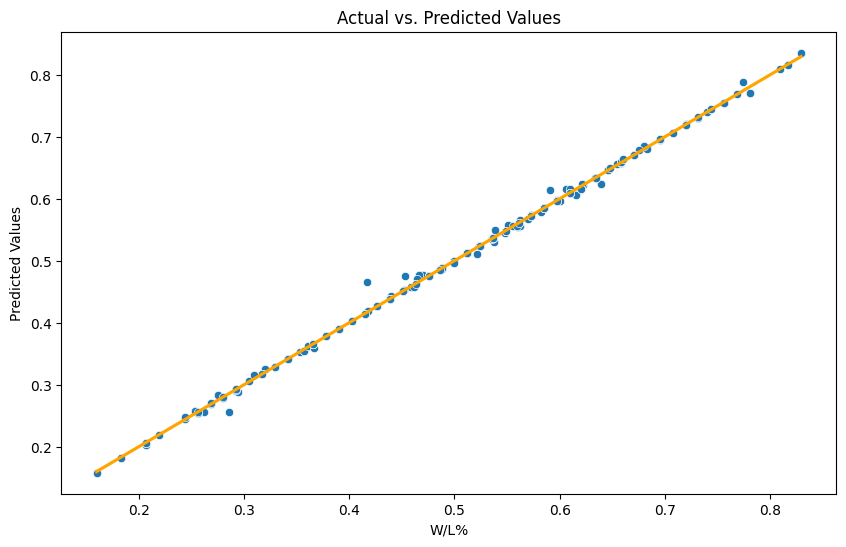

(0.9988050007683367,
 0.0019961321114188146,
 0.0052151493996950345,
 0.9988008378064129)

In [8]:
from xgboost import XGBRegressor
model_XGBRegressor = XGBRegressor()
model_XGBRegressor.fit(X_train, y_train)
pred = model_XGBRegressor.predict(X_test)
evaluate_model(pred, y_test)

Explained Variance Score: 0.9959165357816064
Mean Absolute Error: 0.0033125031414695115
Root Mean Squared Error: 0.0096511647377037
R2 Score: 0.9958931969411453


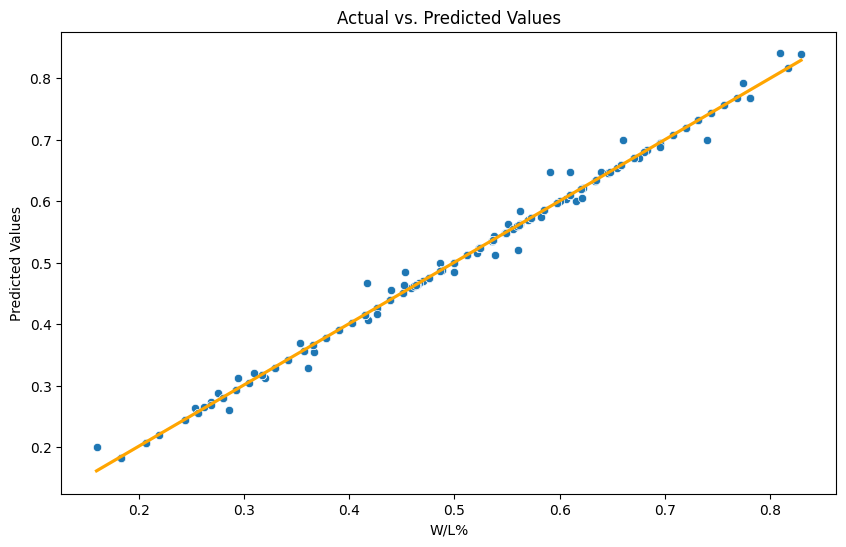

(0.9959165357816064,
 0.0033125031414695115,
 0.0096511647377037,
 0.9958931969411453)

In [9]:
from sklearn import tree
model_DecisionTreeRegressor = tree.DecisionTreeRegressor()
model_DecisionTreeRegressor.fit(X_train, y_train)
pred = model_DecisionTreeRegressor.predict(X_test)
evaluate_model(pred, y_test)

Explained Variance Score: 0.9891904798039736
Mean Absolute Error: 0.00759759165042223
Root Mean Squared Error: 0.015689150509356577
R2 Score: 0.9891471630599554


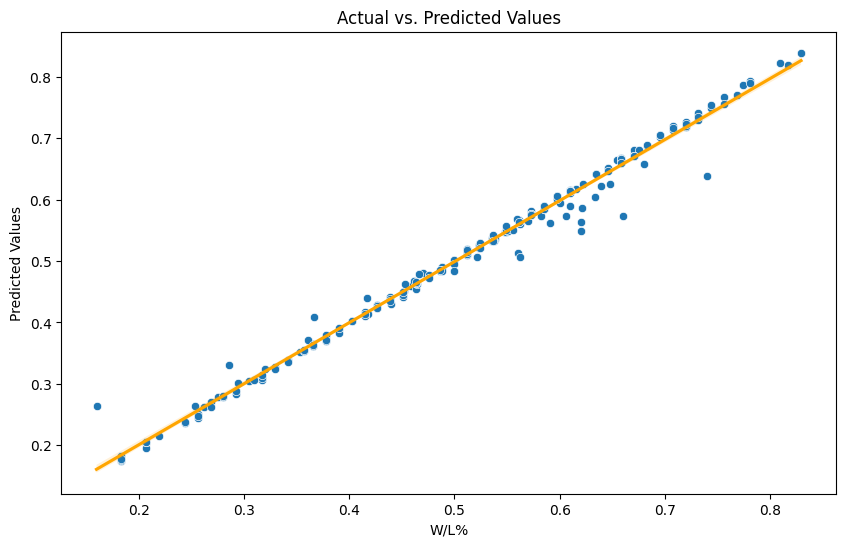

(0.9891904798039736,
 0.00759759165042223,
 0.015689150509356577,
 0.9891471630599554)

In [10]:
from sklearn import linear_model
model_LinearRegression = linear_model.LinearRegression()
model_LinearRegression.fit(X_train, y_train)
pred = model_LinearRegression.predict(X_test)
evaluate_model(pred, y_test)

Explained Variance Score: 0.9985434141313173
Mean Absolute Error: 0.0021025319430343988
Root Mean Squared Error: 0.005760192890126989
R2 Score: 0.9985370870887535


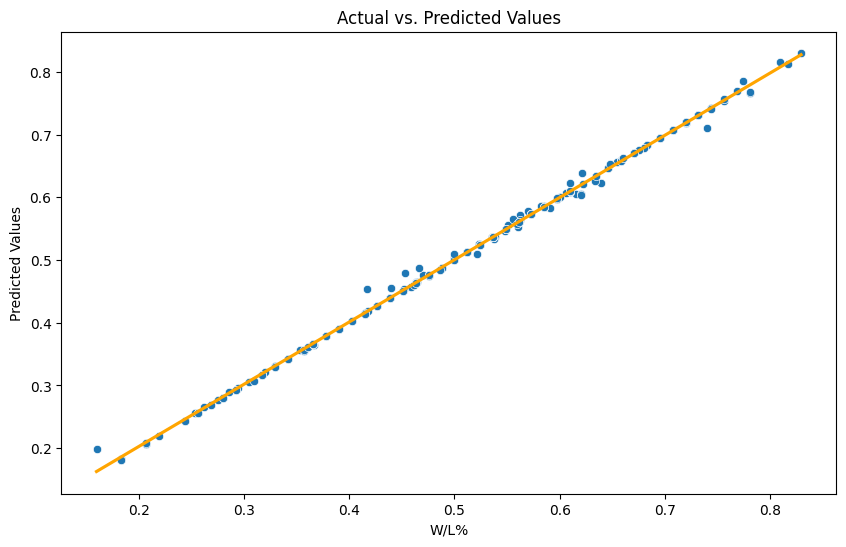

(0.9985434141313173,
 0.0021025319430343988,
 0.005760192890126989,
 0.9985370870887535)

In [11]:
from sklearn.ensemble import RandomForestRegressor
model_RandomForestRegressor = RandomForestRegressor()
model_RandomForestRegressor.fit(X_train, y_train)
pred = model_RandomForestRegressor.predict(X_test)
evaluate_model(pred, y_test)

Explained Variance Score: 0.3494300873775422
Mean Absolute Error: 0.10078919271754588
Root Mean Squared Error: 0.12164787275112907
R2 Score: 0.34754065313101323


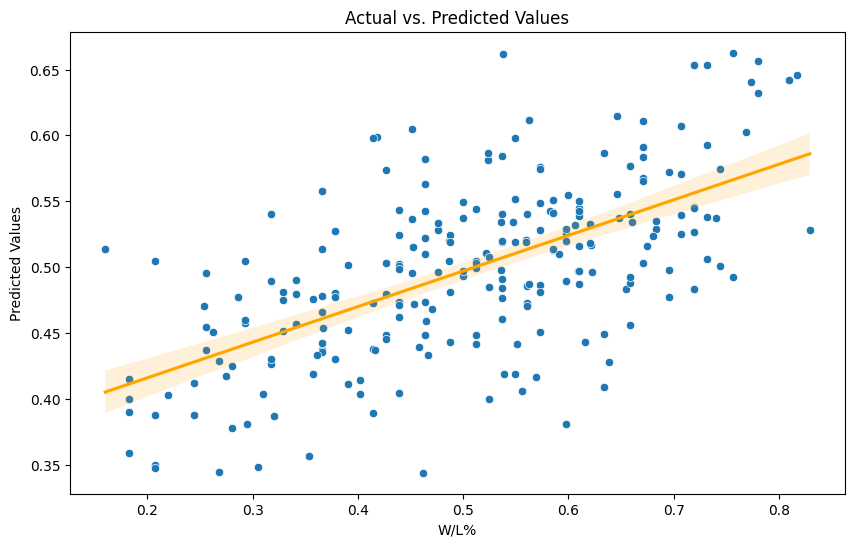

(0.3494300873775422,
 0.10078919271754588,
 0.12164787275112907,
 0.34754065313101323)

In [12]:
from sklearn.svm import SVR
model_SVR = SVR()
model_SVR.fit(X_train, y_train)
pred = model_SVR.predict(X_test)
evaluate_model(pred, y_test)


In [13]:
len(X_test)


238

In [14]:
X_test.index

Index([ 263,  755, 1010,  888,  232,   61, 1043,  330,  391,  836,
       ...
       1044, 1108,  486,  879,  950,  335,  737,  328,  322,   20],
      dtype='int64', length=238)

In [15]:
import sys

In [29]:
def two_teams_pred():
  team1 = input("Enter a team number between 0 and 238, both included: ")
  team2 = input("Enter a team number between 0 and 238, both included: ")

  if not(team1.isdigit()) or not(team2.isdigit()):
    print("Please enter a valid number")
    return

  team1 = int(team1)
  team2 = int(team2)

  if team1 < 0 or team1 > 238 or team2 < 0 or team2 > 238:
     print("Please enter a valid number")
     return


  if team1 == team2:
     print("Please enter two different teams")
     return

  name_team1 = dataframe.iloc[X_test.index[team1]]['Team']+' '+str(dataframe.iloc[X_test.index[team1]]['year'])
  name_team2 = dataframe.iloc[X_test.index[team2]]['Team']+' '+str(dataframe.iloc[X_test.index[team2]]['year'])

  print("Team 1:", name_team1)
  print("Team 2:", name_team2)

  team1_pred = model_XGBRegressor.predict(X_test.iloc[[team1]])[0]
  team2_pred = model_XGBRegressor.predict(X_test.iloc[[team2]])[0]

  print(name_team1," predicted win loss ratio:", team1_pred)
  print(name_team2," predicted win loss ratio:", team2_pred)

  if team1_pred > team2_pred:
    print(name_team1, "is predicted to win")
  elif team1_pred < team2_pred:
    print(name_team2, "is predicted to win")






In [30]:
two_teams_pred()

Enter a team number between 0 and 238, both included: 0
Enter a team number between 0 and 238, both included: 1
Team 1: NYK 1969
Team 2: POR 1989
NYK 1969  predicted win loss ratio: 0.73137593
POR 1989  predicted win loss ratio: 0.720125
NYK 1969 is predicted to win
